# Signal Approximation by neural network

We will reproduce some experiment of the paper "Implicit Neural Representations with Periodic Activation Functions" (Sitzmann, Martel et al.)
https://www.vincentsitzmann.com/siren/



In [1]:
#import packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import random
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from itertools import product

#define device to speed up on gpu, if you can
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
#dev = "cpu"

device = torch.device(dev)  
global device
print("Device :",device)

#Utils function :
#based on a model, reconstruct the image
#create the dataset based on a image file
#warning : the loss of the image is not based on the image reconstruction but based on pixel prediction

def show_image(image,index,title="Ground truth"):
    image =(image*255.0).astype(np.uint8)
    plt.figure(index)
    plt.title(title)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
def reconstruct_image(model,index=0,title="Reconstruct image"):
    size_x = 256
    size_y = 256
    channels = 3
    image = np.zeros((size_x,size_y,channels))
    
    x_channel = torch.arange(0,256)/256
    y_channel = torch.arange(0,256)/256

    x_channel = x_channel.view(-1,1)
    y_channel = y_channel.view(1,-1)

    x_channel = x_channel.repeat(1, 256)
    y_channel = y_channel.repeat(256, 1)

    x_channel = x_channel.view(-1)
    y_channel = y_channel.view(-1)


    xy_channel = torch.stack([x_channel,y_channel],dim=-1)
    raw_image = model(xy_channel).cpu()
    image = torch.reshape(raw_image, (size_x,size_y,3)).detach().numpy()


    show_image(image,index,title)
    
def create_dataset(image):#dataset with r,g,b in [0,1]
    size_x = image.shape[0]
    size_y = image.shape[1]
    channels = image.shape[2]
    
    x_data = np.zeros((size_x*size_y,2))
    y_labels = np.zeros((size_x*size_y,channels))
    for i in range(size_x):
        for j in range(size_y):
            x_ = i/size_x
            y_ = j/size_y
            #print([x_,y_])
            #print(y_labels.shape)
            x_data[i*size_y+j] = [x_,y_]
            y_labels[i*size_y+j] = image[i][j]/255.0
    return x_data,y_labels




#The models to predict, based on the data (coordinate (x,y)), the label (pixel (r,g,b))

#by Vincent Sitzmann, Implicit Neural Representations with Periodic Activation Functions
#https://www.vincentsitzmann.com/siren/
class SineLayer(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias).to(device)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.to(device)
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output#, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations
    
    
#based on David Brellmann, "Fourier Features in Reinforcement Learning with Neural Networks"
#https://openreview.net/forum?id=VO7bAwdWRjg
class fourier_extract_full(nn.Linear):
    def __init__(self, in_features:int, order:int):
        self.order = order
        self.in_features = in_features
        super().__init__(in_features, (order+1)**in_features, bias=True)
        c=np.array(list(product(range(order + 1), repeat=in_features)))
        with torch.no_grad():
            self.weight.copy_(torch.tensor(c, dtype=torch.float32))
        self.weight.requires_grad = False

    def get_output_size(self,):
        return (self.order+1)**self.in_features

    def forward(self, x:torch.Tensor)->torch.Tensor:
        ##print(x.size())
        x = x.to(device)
        x = np.pi*super().forward(x)
        return torch.cos(x)
    
    
#code by me
class simple_mlp(nn.Module):
    def __init__(self,):
        super(simple_mlp, self).__init__()
        self.fc_1 = nn.Linear(2,64).to(device)
        self.fc_2 = nn.Linear(64,64).to(device)
        self.fc_3 = nn.Linear(64,3).to(device)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x
    
#code by me, based on fourier_extract_full
class fourier_mlp(nn.Module):
    def __init__(self,):
        super(fourier_mlp, self).__init__()
        self.fourier_1 = fourier_extract_full(2,8).to(device)
        self.fc_2 = nn.Linear(self.fourier_1.get_output_size(),64).to(device)
        self.fc_3 = nn.Linear(64,64).to(device)
        self.fc_4 = nn.Linear(64,3).to(device)

    def forward(self, x):
        x = x.to(device)
        x = self.fourier_1(x)
        x = F.relu(self.fc_2(x))
        x = F.relu(self.fc_3(x))
        x = self.fc_4(x)
        return x
    
#code by me, based on Siren
class siren_mlp(nn.Module):
    def __init__(self,):
        super(siren_mlp, self).__init__()
        #sorry for this litle trick, the original paper predict only one value
        self.siren_r = Siren(in_features=2, out_features=1, hidden_features=64, hidden_layers=1, outermost_linear=True).to(device)
        self.siren_g = Siren(in_features=2, out_features=1, hidden_features=64, hidden_layers=1, outermost_linear=True).to(device)
        self.siren_b = Siren(in_features=2, out_features=1, hidden_features=64, hidden_layers=1, outermost_linear=True).to(device)

    def forward(self,x):
        x = x.to(device)
        return torch.cat([self.siren_r(x),self.siren_g(x),self.siren_b(x),],dim=-1)
    
    
#code by me
class triangular_features_extraction(nn.Linear):
    def __init__(self, in_features:int, order:int,flatten=True):
        self.flatten = flatten
        self.order = order
        self.in_features = in_features
        self.size_ecart = 1/(self.order-1)
        self.var_power = 2.0
        
        self.size_pic = self.var_power*self.size_ecart

        super().__init__(in_features, (order)*in_features, bias=True)


    def forward(self, x:torch.Tensor)->torch.Tensor:
        x = x.type(torch.float64).to(device)
        out= torch.zeros(x.shape[0],x.shape[1],self.order).to(device)

        
        for i in range(self.order):
            out[:,:,i] = x-i*self.size_ecart
        mean = self.size_pic
        out = torch.min(torch.relu(out+self.size_pic),torch.relu(self.size_pic-out)).to(device)/(self.size_pic)
        
        
        if self.flatten:
            return torch.flatten(out, start_dim=1)
        else:
            return out#torch.flatten(out, start_dim=1)

#code by me
class triangular_mlp(nn.Module):
    def __init__(self,):
        super(triangular_mlp, self).__init__()
        self.triangular_extraction = triangular_features_extraction(2,8).to(device)
        self.fc_1 = nn.Linear(16,64).to(device)
        self.fc_2 = nn.Linear(64,3).to(device)
        #self.fc_3 = nn.Linear(64,3).to(device)

    def forward(self, x):
        x = x.to(device)
        x = self.triangular_extraction(x)
        x = F.relu(self.fc_1(x))
        #x = F.relu(self.fc_2(x))
        x = self.fc_2(x)
        return x
        
#we define the trainning loop
def train_model(
    model=simple_mlp(),
    dataset=create_dataset(cv2.imread("lena.png")),
    epochs=10,
    plot_step=1,
    ):
    loss_func = torch.nn.MSELoss()
    dataset = TensorDataset( torch.Tensor(dataset[0]), torch.Tensor(dataset[1]) )
    dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_array = []


    for epoch in range(epochs):

        for id_batch, (inputs, labels) in enumerate(dataloader):
                optimizer.zero_grad()
                labels_predict = model(inputs).cpu()
                loss_train = loss_func(labels_predict, labels)
                loss_train.backward()
                optimizer.step()
                loss_array.append(loss_train.detach().numpy())
                #print(id_batch)
                if id_batch==0:
                    if epoch%plot_step==0:
                        print('Epoch: %d, Loss_train: %.3f ' % (epoch+1, loss_train))
    plt.figure(42)
    plt.title("Loss curve")
    plt.xlabel("Trainning")
    plt.ylabel("Loss")
    plt.plot(loss_array)
    print("Finished with a loss for 100 last loss : ",np.mean(loss_array[-100:]))
    print("Finished with a loss for 50 last loss : ",np.mean(loss_array[-50:]))
    




Device : cuda:0


# We will benchmark different way to extract the data to obtain the pixel prediction

The extraction :

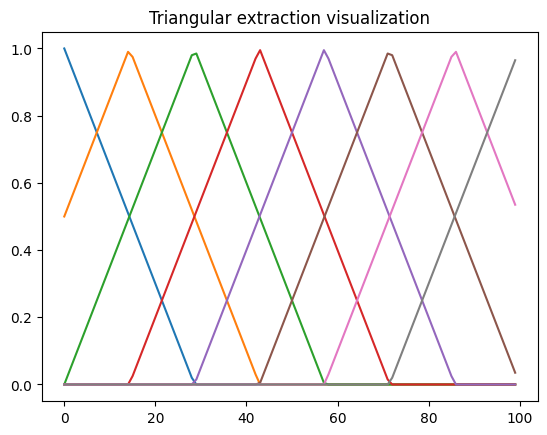

In [2]:
layer = triangular_features_extraction(100,8,flatten=False)
input_x = torch.arange(0,100)/100
input_x = input_x.view(1,-1)
output_y = layer(input_x).cpu()
plt.title("Triangular extraction visualization")
plt.plot(output_y[0])


torch.Size([1, 100, 1])


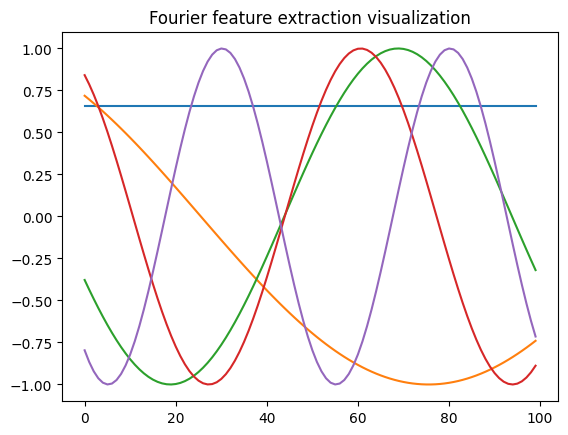

In [3]:
layer = fourier_extract_full(1,4).to(device)

input_x = torch.arange(0,100)/100
input_x = input_x.view(1,-1,1).to(device)
print(input_x.shape)
output_y = layer(input_x).cpu()
plt.title("Fourier feature extraction visualization")
plt.plot(output_y[0].detach().numpy())

torch.Size([1, 100, 1])


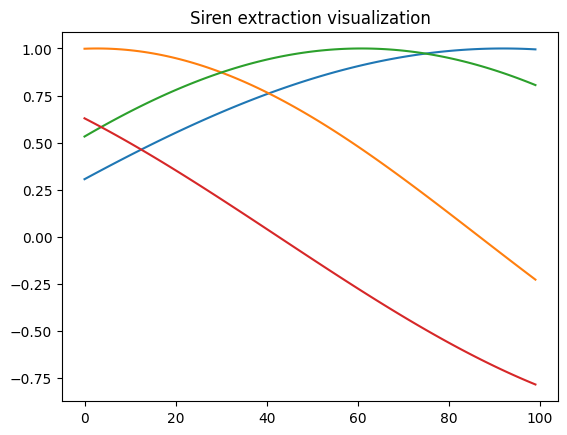

In [4]:
layer = SineLayer(1,4).to(device)

input_x = torch.arange(0,100)/100
input_x = input_x.view(1,-1,1).to(device)
print(input_x.shape)
output_y = layer(input_x).cpu()
plt.title("Siren extraction visualization")
plt.plot(output_y[0].detach().numpy())

The test of the model :

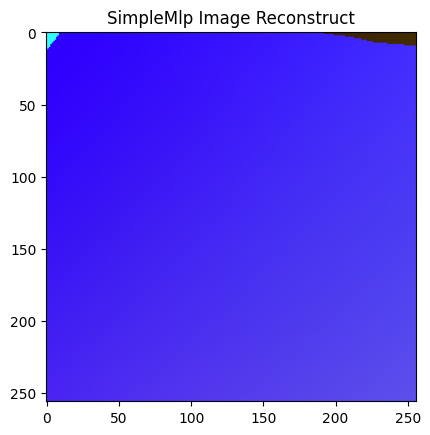

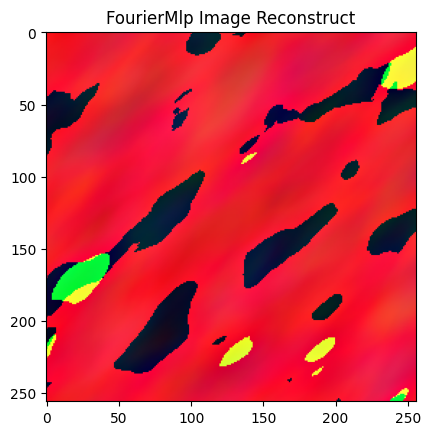

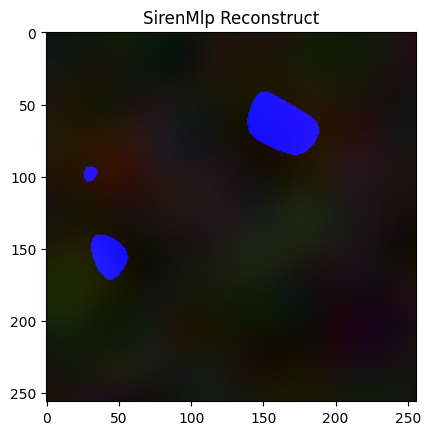

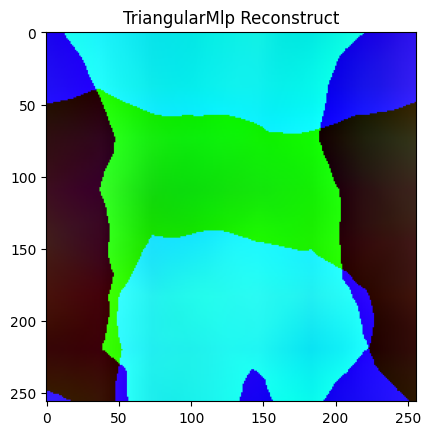

In [5]:
#Verify all model and show data
model = simple_mlp()
reconstruct_image(model,1,"SimpleMlp Image Reconstruct")

model = fourier_mlp()
reconstruct_image(model,2,"FourierMlp Image Reconstruct")

model = siren_mlp()
reconstruct_image(model,3,"SirenMlp Reconstruct")

model = triangular_mlp()
reconstruct_image(model,4,"TriangularMlp Reconstruct")



The data :

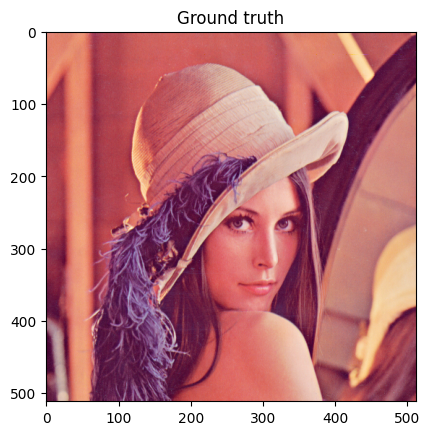

In [6]:
show_image(cv2.imread("lena.png")/255.0,5)

# Result of the image prediction

Epoch: 1, Loss_train: 0.316 
Epoch: 2, Loss_train: 0.028 
Epoch: 3, Loss_train: 0.027 
Epoch: 4, Loss_train: 0.026 
Epoch: 5, Loss_train: 0.023 
Epoch: 6, Loss_train: 0.023 
Epoch: 7, Loss_train: 0.023 
Epoch: 8, Loss_train: 0.020 
Epoch: 9, Loss_train: 0.021 
Epoch: 10, Loss_train: 0.021 
Finished with a loss for 100 last loss :  0.019392015
Finished with a loss for 50 last loss :  0.019266551
simple_mlp(
  (fc_1): Linear(in_features=2, out_features=64, bias=True)
  (fc_2): Linear(in_features=64, out_features=64, bias=True)
  (fc_3): Linear(in_features=64, out_features=3, bias=True)
)


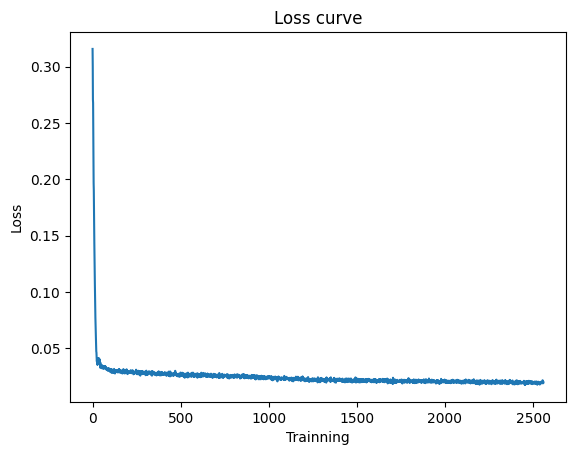

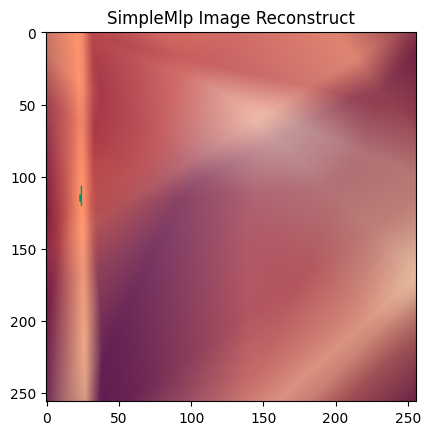

In [7]:
model = simple_mlp()
train_model(model)
reconstruct_image(model,1,"SimpleMlp Image Reconstruct")
print(model)

Epoch: 1, Loss_train: 0.349 
Epoch: 2, Loss_train: 0.010 
Epoch: 3, Loss_train: 0.008 
Epoch: 4, Loss_train: 0.006 
Epoch: 5, Loss_train: 0.005 
Epoch: 6, Loss_train: 0.005 
Epoch: 7, Loss_train: 0.004 
Epoch: 8, Loss_train: 0.005 
Epoch: 9, Loss_train: 0.004 
Epoch: 10, Loss_train: 0.004 
Finished with a loss for 100 last loss :  0.003795425
Finished with a loss for 50 last loss :  0.003759256
fourier_mlp(
  (fourier_1): fourier_extract_full(in_features=2, out_features=81, bias=True)
  (fc_2): Linear(in_features=81, out_features=64, bias=True)
  (fc_3): Linear(in_features=64, out_features=64, bias=True)
  (fc_4): Linear(in_features=64, out_features=3, bias=True)
)


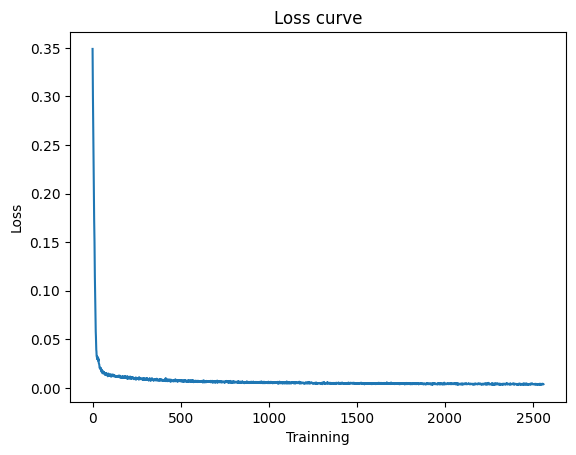

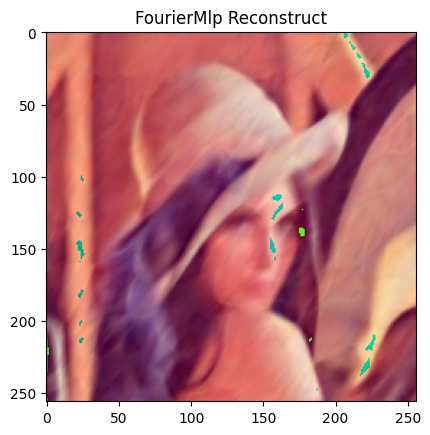

In [8]:
model = fourier_mlp()
train_model(model)
reconstruct_image(model,2,"FourierMlp Reconstruct")
print(model)

Epoch: 1, Loss_train: 0.357 
Epoch: 2, Loss_train: 0.007 
Epoch: 3, Loss_train: 0.006 
Epoch: 4, Loss_train: 0.005 
Epoch: 5, Loss_train: 0.005 
Epoch: 6, Loss_train: 0.005 
Epoch: 7, Loss_train: 0.005 
Epoch: 8, Loss_train: 0.005 
Epoch: 9, Loss_train: 0.005 
Epoch: 10, Loss_train: 0.005 
Finished with a loss for 100 last loss :  0.0046765325
Finished with a loss for 50 last loss :  0.00470019
siren_mlp(
  (siren_r): Siren(
    (net): Sequential(
      (0): SineLayer(
        (linear): Linear(in_features=2, out_features=64, bias=True)
      )
      (1): SineLayer(
        (linear): Linear(in_features=64, out_features=64, bias=True)
      )
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (siren_g): Siren(
    (net): Sequential(
      (0): SineLayer(
        (linear): Linear(in_features=2, out_features=64, bias=True)
      )
      (1): SineLayer(
        (linear): Linear(in_features=64, out_features=64, bias=True)
      )
      (2): Linear(in_features=64, out_fe

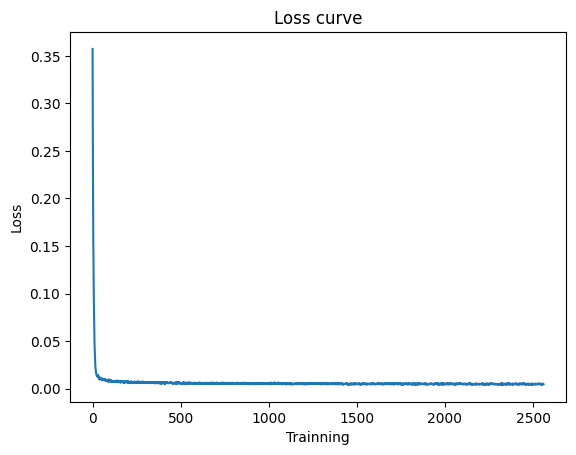

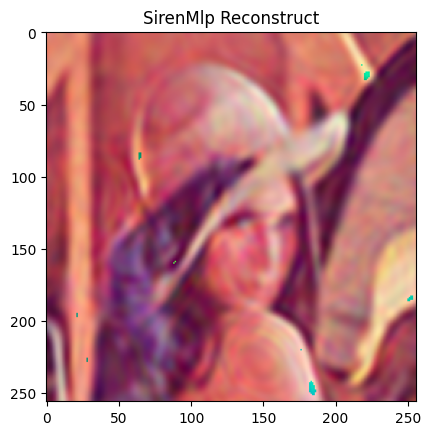

In [9]:
model = siren_mlp()
train_model(model)
reconstruct_image(model,4,"SirenMlp Reconstruct")
print(model)

Epoch: 1, Loss_train: 0.330 
Epoch: 2, Loss_train: 0.022 
Epoch: 3, Loss_train: 0.017 
Epoch: 4, Loss_train: 0.016 
Epoch: 5, Loss_train: 0.014 
Epoch: 6, Loss_train: 0.014 
Epoch: 7, Loss_train: 0.013 
Epoch: 8, Loss_train: 0.012 
Epoch: 9, Loss_train: 0.013 
Epoch: 10, Loss_train: 0.013 
Finished with a loss for 100 last loss :  0.011775701
Finished with a loss for 50 last loss :  0.011684129
triangular_mlp(
  (triangular_extraction): triangular_features_extraction(in_features=2, out_features=16, bias=True)
  (fc_1): Linear(in_features=16, out_features=64, bias=True)
  (fc_2): Linear(in_features=64, out_features=3, bias=True)
)


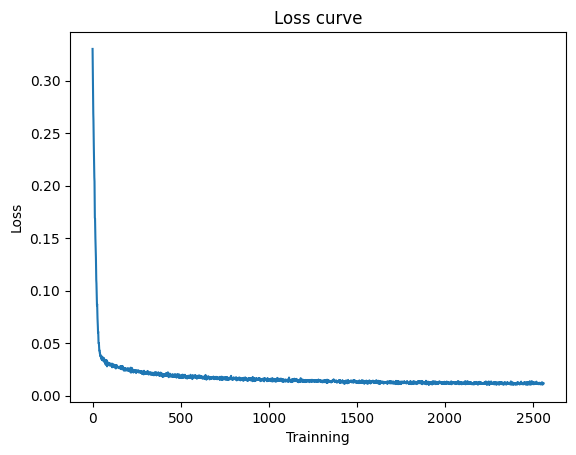

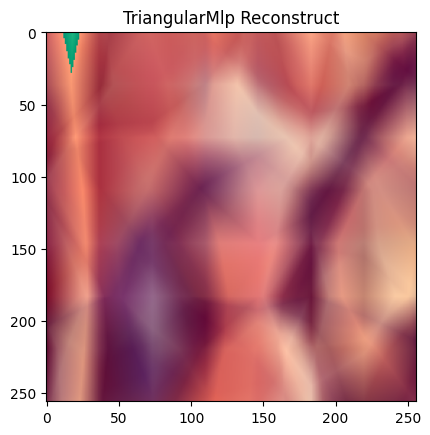

In [10]:
model = triangular_mlp()
train_model(model)
reconstruct_image(model,4,"TriangularMlp Reconstruct")
print(model)


# After the image reconstruction, the 2D signal reconstruction :

### 

In [11]:

def show_data(data,labels,index,title="Ground truth",size=128):
    X,Y,Z = data[:,0],data[:,1],labels

    X = np.reshape(X,(size,size))
    Y = np.reshape(Y,(size,size))
    Z = np.reshape(Z,(size,size))
    
    fig = plt.figure(index,figsize=(4, 4))
    #plt.title(title)
    fig.suptitle(title)
    ax = fig.add_subplot()
    scats = ax.scatter(X,Y,c=Z, cmap = "RdBu")#RdBu
    #fig.colorbar(scats)
    
def reconstruct_Helmholtz(model,index=1,title="Reconstruct image",size=128):
    size_x = size
    size_y = size
    channels = 1
    
    
    image = np.zeros((size_x,size_y,channels))
    x_channel = (torch.arange(0,size_x)/size_x)*2 -1
    y_channel = (torch.arange(0,size_y)/size_y)*2 -1
    x_channel = x_channel.view(-1,1)
    y_channel = y_channel.view(1,-1)
    x_channel = x_channel.repeat(1, size_x)
    y_channel = y_channel.repeat(size_y, 1)

    x_channel = x_channel.view(-1)
    y_channel = y_channel.view(-1)


    xy_channel = torch.stack([x_channel,y_channel],dim=-1)
    raw_image = model(xy_channel).cpu()

    show_data(xy_channel.detach(),raw_image.detach(),index,title,size)
    
    

def create_dataset_Helmholtz(size=128,size_sin=4):
    size_x=size
    size_y=size
    x_data = np.zeros((size_x*size_y,2))
    y_labels = np.zeros((size_x*size_y,1))
    for i in range(size_x):
        for j in range(size_y):
            x_ = (i/size_x)*2-1
            y_ = (j/size_y)*2-1

            x_data[i*size_y+j] = [x_,y_]
            R = np.sqrt((x_)**2 + y_**2)
            y_labels[i*size_y+j] = np.sin(R*3.1415*size_sin) 
    return x_data,y_labels
def create_dataset_Helmholtz_max(size=128):
    return create_dataset_Helmholtz(size=128,size_sin=10)


def create_dataset_hard(size=128):
    size_x=size
    size_y=size
    x_data = np.zeros((size_x*size_y,2))
    y_labels = np.zeros((size_x*size_y,1))
    for i in range(size_x):
        for j in range(size_y):
            x_ = (i/size_x)*2-1
            y_ = (j/size_y)*2-1

            x_data[i*size_y+j] = [x_,y_]
            y_labels[i*size_y+j] = np.sin(3.1415*(2*x_+3*y_)*2*x_+random.random())
            
            
    return x_data,y_labels



The 2D signal to Reconstruct :

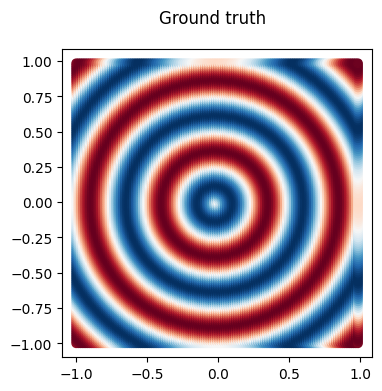

In [12]:
(data,label) = create_dataset_Helmholtz(size=128)
show_data(data,label,1,size=128)

To solve this task, we can choose between 2 types of neural network :

    minimal : Obtain reconstruction with the smaller model to see the benefits and limits of each way to extract the data
    maximal : Obtain a reconstruction with the higher accuracy (with bigger model), to test the model on harder task after that

In [13]:
#Minimal neural network
class simple_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(simple_mlp_Helmholtz, self).__init__()
        self.fc_1 = nn.Linear(2,32).to(device)
        self.fc_2 = nn.Linear(32,1).to(device)
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x
    
class triangular_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(triangular_mlp_Helmholtz, self).__init__()
        self.input_decompo = triangular_features_extraction(2,8).to(device)
        self.fc_1 = nn.Linear(16,1).to(device)
        #self.fc_2 = nn.Linear(32,1).to(device)


    def forward(self, x):
        x = x.to(device)
        x = self.input_decompo((x+1)/2)
        #x = F.relu(self.fc_1(x))
        x = self.fc_1(x)
        return x
#code by me
class fourier_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(fourier_mlp_Helmholtz, self).__init__()
        self.fourier_1 = fourier_extract_full(2,4).to(device)
        self.fc_2 = nn.Linear(self.fourier_1.get_output_size(),1).to(device)
        #self.fc_3 = nn.Linear(64,1).to(device)


    def forward(self, x):
        x = x.to(device)
        x = self.fourier_1(x)
        #x = F.relu(self.fc_2(x))
        x = self.fc_2(x)
        return x
    
#code by me
class siren_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(siren_mlp_Helmholtz, self).__init__()
        self.siren = Siren(in_features=2, out_features=1, hidden_features=16, hidden_layers=0, outermost_linear=False).to(device)

    def forward(self,x):
        x = x.to(device)
        return self.siren(x)
    


In [14]:
#Normal model
class simple_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(simple_mlp_Helmholtz, self).__init__()
        self.fc_1 = nn.Linear(2,32).to(device)
        self.fc_2 = nn.Linear(32,32).to(device)
        self.fc_3 = nn.Linear(32,1).to(device)
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x
    
class siren_fake_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(siren_fake_mlp_Helmholtz, self).__init__()
        self.fc_1 = nn.Linear(2,32).to(device)
        self.fc_2 = nn.Linear(32,32).to(device)
        self.fc_3 = nn.Linear(32,1).to(device)
    def forward(self, x):
        x = x.to(device)
        x = torch.sin(self.fc_1(x))
        x = torch.sin(self.fc_2(x))
        x = self.fc_3(x)
        return x
    
class triangular_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(triangular_mlp_Helmholtz, self).__init__()
        self.input_decompo = triangular_features_extraction(2,8).to(device)
        self.fc_1 = nn.Linear(16,32).to(device)
        self.fc_2 = nn.Linear(32,1).to(device)


    def forward(self, x):
        x = x.to(device)
        x = self.input_decompo((x+1)/2)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x
    
    
#code by me
class fourier_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(fourier_mlp_Helmholtz, self).__init__()
        self.fourier_1 = fourier_extract_full(2,8).to(device)
        self.fc_2 = nn.Linear(self.fourier_1.get_output_size(),32).to(device)
        self.fc_3 = nn.Linear(32,1).to(device)


    def forward(self, x):
        x = x.to(device)
        x = self.fourier_1(x)
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x
    
#code by me
class siren_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(siren_mlp_Helmholtz, self).__init__()
        self.siren = Siren(in_features=2, out_features=1, hidden_features=32, hidden_layers=1, outermost_linear=False).to(device)

    def forward(self,x):
        x = x.to(device)
        return self.siren(x)
    

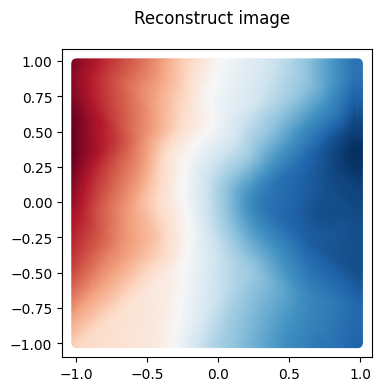

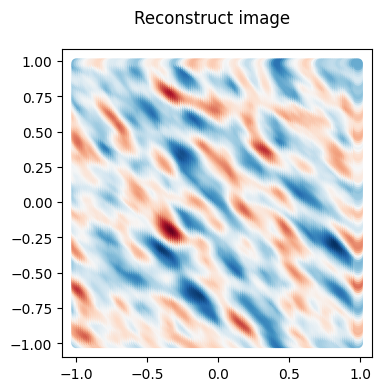

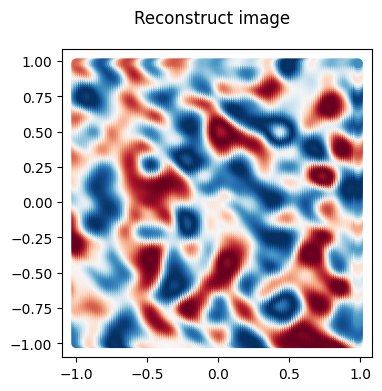

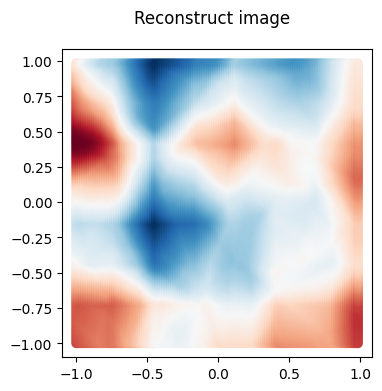

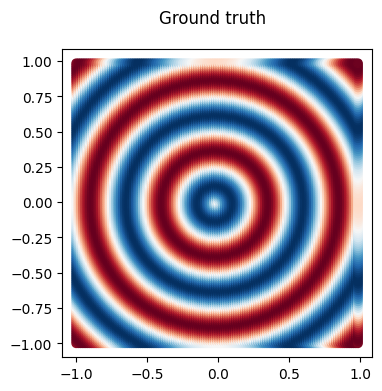

In [15]:
#Verify models and data 
model = simple_mlp_Helmholtz()
reconstruct_Helmholtz(model,index=1)

model = fourier_mlp_Helmholtz()
reconstruct_Helmholtz(model,index=2)

model = siren_mlp_Helmholtz()
reconstruct_Helmholtz(model,index=3)

model = triangular_mlp_Helmholtz()
reconstruct_Helmholtz(model,index=4)


(data,label) = create_dataset_Helmholtz(size=128)
show_data(data,label,5,size=128)


# Result of the 2D signal approximation, easy version

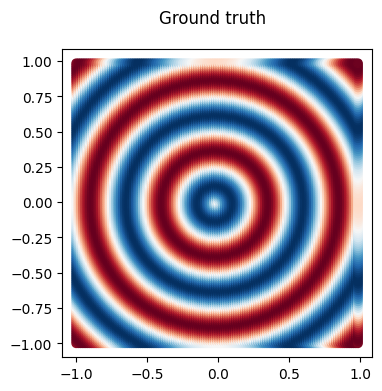

In [16]:
#Simple data
(data,label) = create_dataset_Helmholtz(size=128)
show_data(data,label,5,size=128)

Epoch: 1, Loss_train: 0.493 
Epoch: 51, Loss_train: 0.370 
Epoch: 101, Loss_train: 0.265 
Epoch: 151, Loss_train: 0.170 
Epoch: 201, Loss_train: 0.118 
Epoch: 251, Loss_train: 0.113 
Epoch: 301, Loss_train: 0.089 
Epoch: 351, Loss_train: 0.068 
Epoch: 401, Loss_train: 0.063 
Epoch: 451, Loss_train: 0.053 
Finished with a loss for 100 last loss :  0.05029042
Finished with a loss for 50 last loss :  0.04997286
simple_mlp_Helmholtz(
  (fc_1): Linear(in_features=2, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=1, bias=True)
)


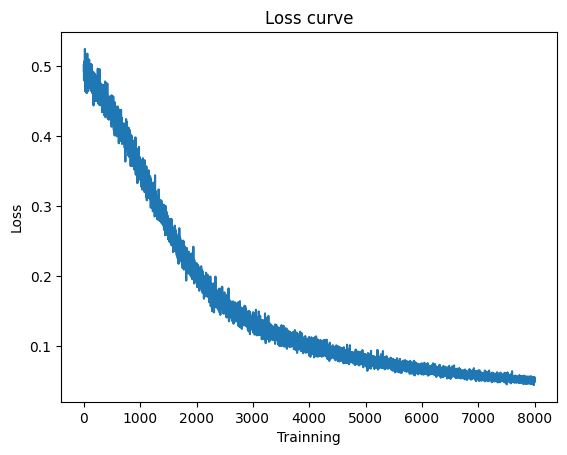

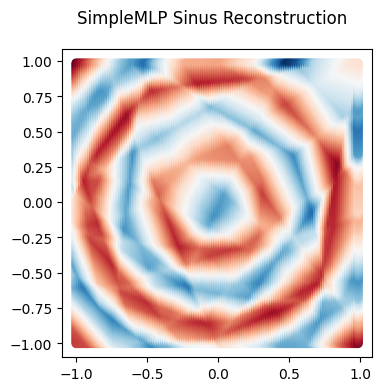

In [17]:
model = simple_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=1,title="SimpleMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.530 
Epoch: 51, Loss_train: 0.496 
Epoch: 101, Loss_train: 0.480 
Epoch: 151, Loss_train: 0.471 
Epoch: 201, Loss_train: 0.472 
Epoch: 251, Loss_train: 0.483 
Epoch: 301, Loss_train: 0.481 
Epoch: 351, Loss_train: 0.487 
Epoch: 401, Loss_train: 0.483 
Epoch: 451, Loss_train: 0.462 
Finished with a loss for 100 last loss :  0.46167278
Finished with a loss for 50 last loss :  0.4612229
siren_fake_mlp_Helmholtz(
  (fc_1): Linear(in_features=2, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=1, bias=True)
)


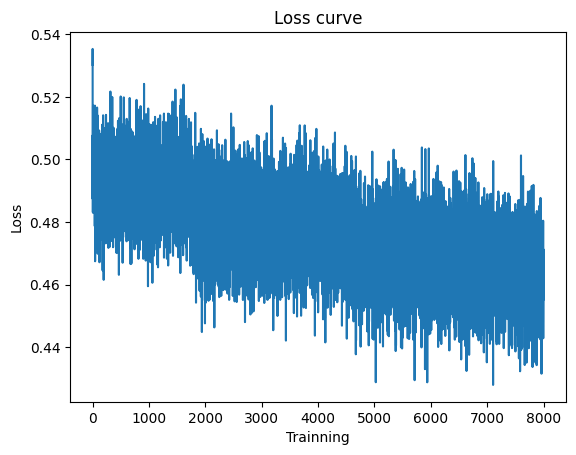

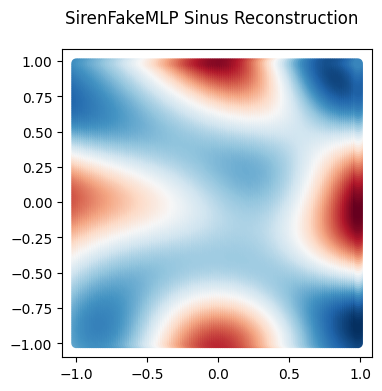

In [18]:
model = siren_fake_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=1,title="SirenFakeMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.577 
Epoch: 51, Loss_train: 0.001 
Epoch: 101, Loss_train: 0.000 
Epoch: 151, Loss_train: 0.000 
Epoch: 201, Loss_train: 0.000 
Epoch: 251, Loss_train: 0.000 
Epoch: 301, Loss_train: 0.000 
Epoch: 351, Loss_train: 0.000 
Epoch: 401, Loss_train: 0.000 
Epoch: 451, Loss_train: 0.000 
Finished with a loss for 100 last loss :  0.00025416855
Finished with a loss for 50 last loss :  0.00025535215
fourier_mlp_Helmholtz(
  (fourier_1): fourier_extract_full(in_features=2, out_features=81, bias=True)
  (fc_2): Linear(in_features=81, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=1, bias=True)
)


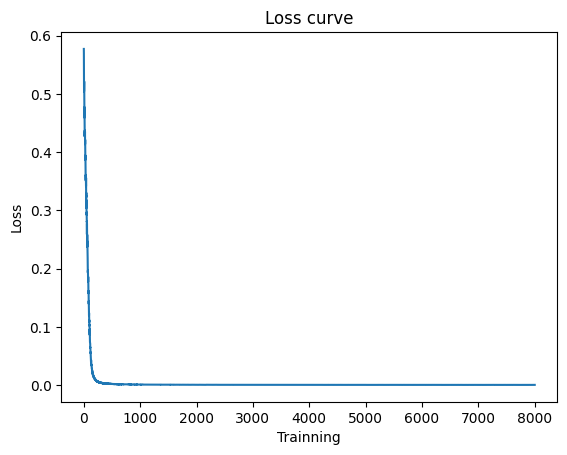

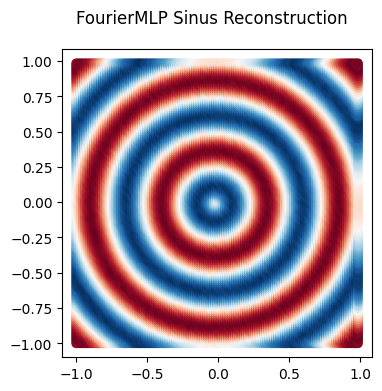

In [19]:

model = fourier_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=2,title="FourierMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 1.173 
Epoch: 51, Loss_train: 0.043 
Epoch: 101, Loss_train: 0.036 
Epoch: 151, Loss_train: 0.043 
Epoch: 201, Loss_train: 0.034 
Epoch: 251, Loss_train: 0.027 
Epoch: 301, Loss_train: 0.043 
Epoch: 351, Loss_train: 0.027 
Epoch: 401, Loss_train: 0.032 
Epoch: 451, Loss_train: 0.044 
Finished with a loss for 100 last loss :  0.030894043
Finished with a loss for 50 last loss :  0.031835414
siren_mlp_Helmholtz(
  (siren): Siren(
    (net): Sequential(
      (0): SineLayer(
        (linear): Linear(in_features=2, out_features=32, bias=True)
      )
      (1): SineLayer(
        (linear): Linear(in_features=32, out_features=32, bias=True)
      )
      (2): SineLayer(
        (linear): Linear(in_features=32, out_features=1, bias=True)
      )
    )
  )
)


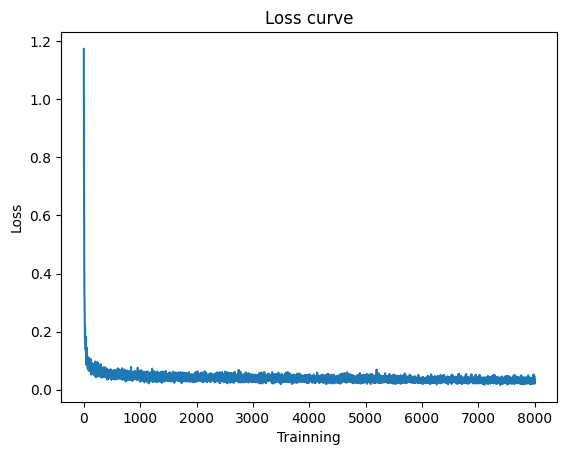

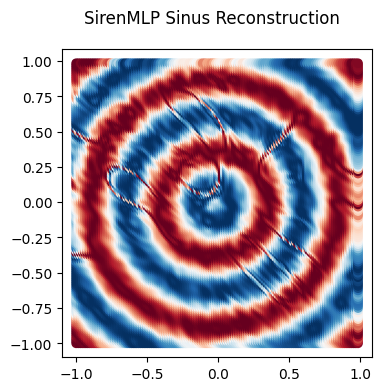

In [20]:
model = siren_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=4,title="SirenMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.490 
Epoch: 51, Loss_train: 0.119 
Epoch: 101, Loss_train: 0.029 
Epoch: 151, Loss_train: 0.014 
Epoch: 201, Loss_train: 0.011 
Epoch: 251, Loss_train: 0.008 
Epoch: 301, Loss_train: 0.008 
Epoch: 351, Loss_train: 0.007 
Epoch: 401, Loss_train: 0.007 
Epoch: 451, Loss_train: 0.006 
Finished with a loss for 100 last loss :  0.0058734645
Finished with a loss for 50 last loss :  0.005862781
triangular_mlp_Helmholtz(
  (input_decompo): triangular_features_extraction(in_features=2, out_features=16, bias=True)
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=1, bias=True)
)


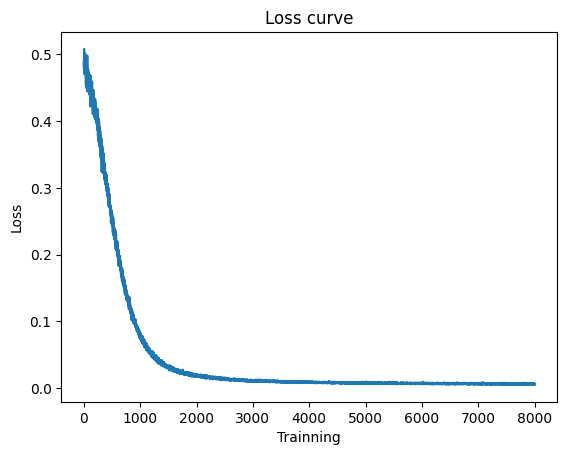

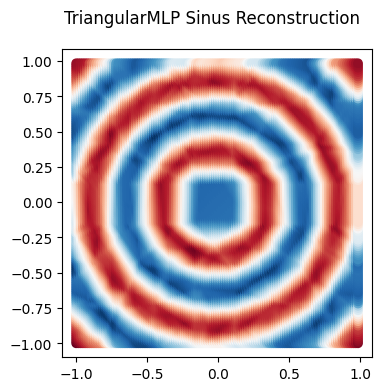

In [21]:
model = triangular_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=5,title="TriangularMLP Sinus Reconstruction")
print(model)

# Result of the 2D signal approximation,  moderate version

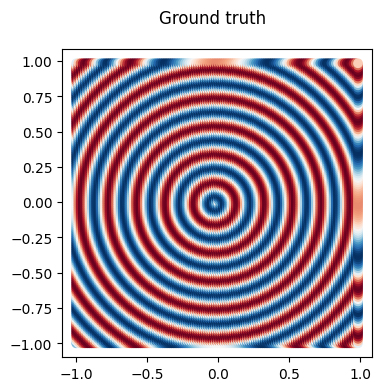

In [22]:
#moderate data
(data,label) = create_dataset_Helmholtz_max(size=128)
show_data(data,label,5,size=128)

Epoch: 1, Loss_train: 0.530 
Epoch: 51, Loss_train: 0.483 
Epoch: 101, Loss_train: 0.491 
Epoch: 151, Loss_train: 0.506 
Epoch: 201, Loss_train: 0.494 
Epoch: 251, Loss_train: 0.502 
Epoch: 301, Loss_train: 0.479 
Epoch: 351, Loss_train: 0.457 
Epoch: 401, Loss_train: 0.478 
Epoch: 451, Loss_train: 0.454 
Finished with a loss for 100 last loss :  0.45709983
Finished with a loss for 50 last loss :  0.4561506
simple_mlp_Helmholtz(
  (fc_1): Linear(in_features=2, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=1, bias=True)
)


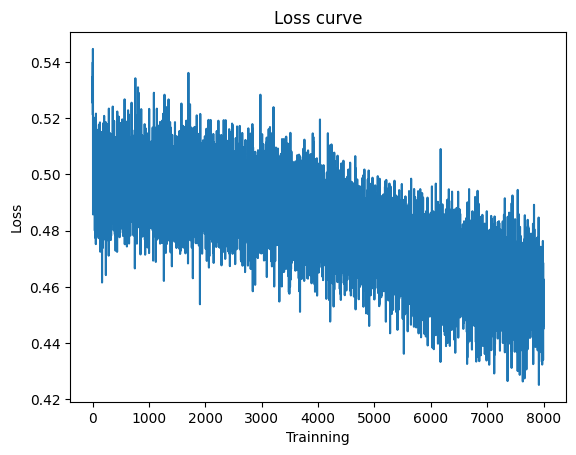

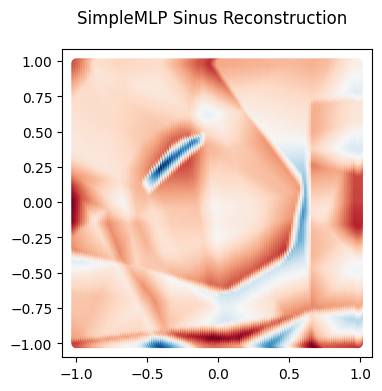

In [23]:
model = simple_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz_max(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=1,title="SimpleMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.517 
Epoch: 51, Loss_train: 0.019 
Epoch: 101, Loss_train: 0.007 
Epoch: 151, Loss_train: 0.005 
Epoch: 201, Loss_train: 0.004 
Epoch: 251, Loss_train: 0.005 
Epoch: 301, Loss_train: 0.004 
Epoch: 351, Loss_train: 0.004 
Epoch: 401, Loss_train: 0.004 
Epoch: 451, Loss_train: 0.004 
Finished with a loss for 100 last loss :  0.003863824
Finished with a loss for 50 last loss :  0.0038743636
fourier_mlp_Helmholtz(
  (fourier_1): fourier_extract_full(in_features=2, out_features=81, bias=True)
  (fc_2): Linear(in_features=81, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=1, bias=True)
)


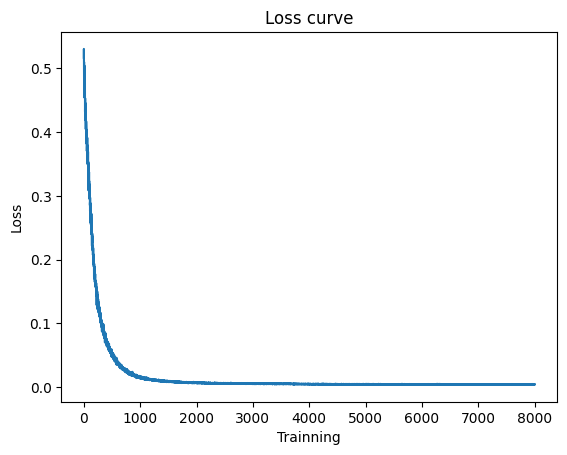

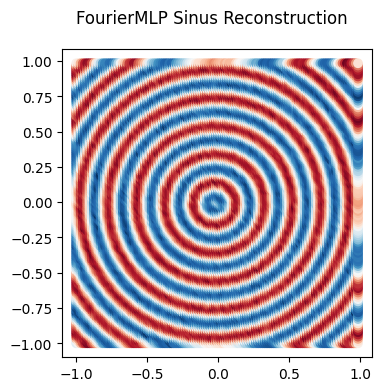

In [24]:
model = fourier_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz_max(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=2,title="FourierMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 1.053 
Epoch: 51, Loss_train: 0.059 
Epoch: 101, Loss_train: 0.063 
Epoch: 151, Loss_train: 0.058 
Epoch: 201, Loss_train: 0.049 
Epoch: 251, Loss_train: 0.036 
Epoch: 301, Loss_train: 0.047 
Epoch: 351, Loss_train: 0.041 
Epoch: 401, Loss_train: 0.049 
Epoch: 451, Loss_train: 0.053 
Finished with a loss for 100 last loss :  0.05355373
Finished with a loss for 50 last loss :  0.05266197
siren_mlp_Helmholtz(
  (siren): Siren(
    (net): Sequential(
      (0): SineLayer(
        (linear): Linear(in_features=2, out_features=32, bias=True)
      )
      (1): SineLayer(
        (linear): Linear(in_features=32, out_features=32, bias=True)
      )
      (2): SineLayer(
        (linear): Linear(in_features=32, out_features=1, bias=True)
      )
    )
  )
)


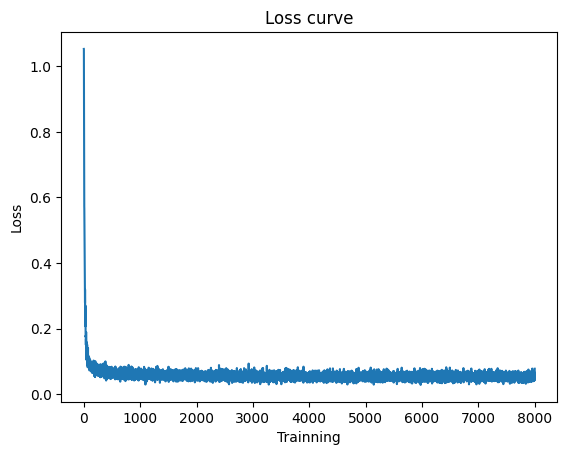

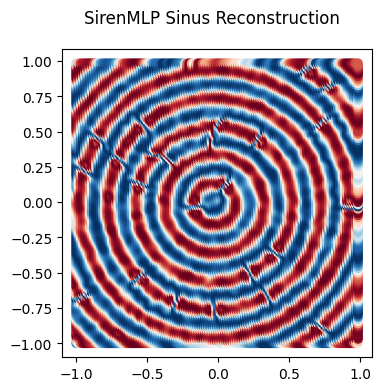

In [25]:
model = siren_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz_max(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=4,title="SirenMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.551 
Epoch: 51, Loss_train: 0.495 
Epoch: 101, Loss_train: 0.480 
Epoch: 151, Loss_train: 0.480 
Epoch: 201, Loss_train: 0.478 
Epoch: 251, Loss_train: 0.465 
Epoch: 301, Loss_train: 0.461 
Epoch: 351, Loss_train: 0.448 
Epoch: 401, Loss_train: 0.447 
Epoch: 451, Loss_train: 0.435 
Finished with a loss for 100 last loss :  0.42490277
Finished with a loss for 50 last loss :  0.42498192
triangular_mlp_Helmholtz(
  (input_decompo): triangular_features_extraction(in_features=2, out_features=16, bias=True)
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=1, bias=True)
)


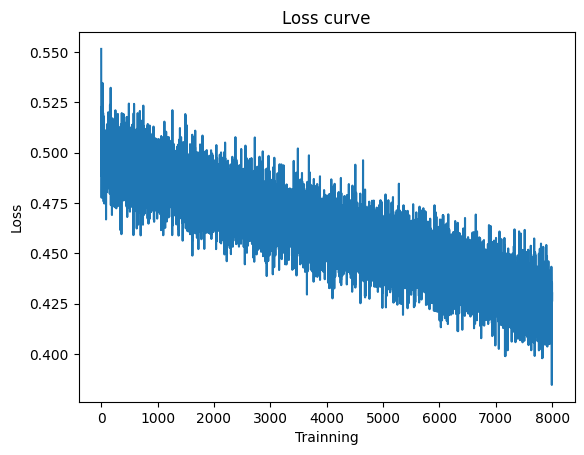

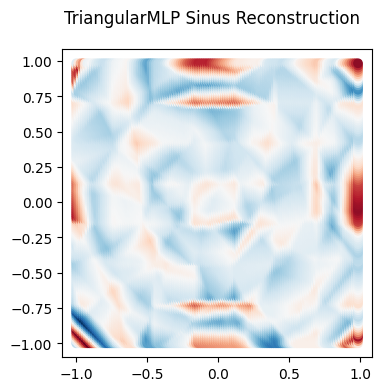

In [26]:
model = triangular_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz_max(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=5,title="TriangularMLP Sinus Reconstruction")
print(model)

# Result of the 2D signal approximation,  hard version

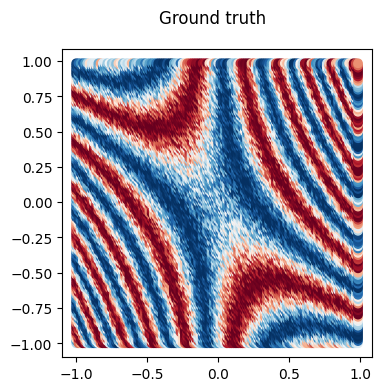

In [27]:
#hard data
(data,label) = create_dataset_hard(size=128)
show_data(data,label,5,size=128)

Epoch: 1, Loss_train: 0.476 
Epoch: 51, Loss_train: 0.326 
Epoch: 101, Loss_train: 0.281 
Epoch: 151, Loss_train: 0.262 
Epoch: 201, Loss_train: 0.261 
Epoch: 251, Loss_train: 0.230 
Epoch: 301, Loss_train: 0.231 
Epoch: 351, Loss_train: 0.195 
Epoch: 401, Loss_train: 0.242 
Epoch: 451, Loss_train: 0.226 
Finished with a loss for 100 last loss :  0.21624474
Finished with a loss for 50 last loss :  0.2165966
simple_mlp_Helmholtz(
  (fc_1): Linear(in_features=2, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=1, bias=True)
)


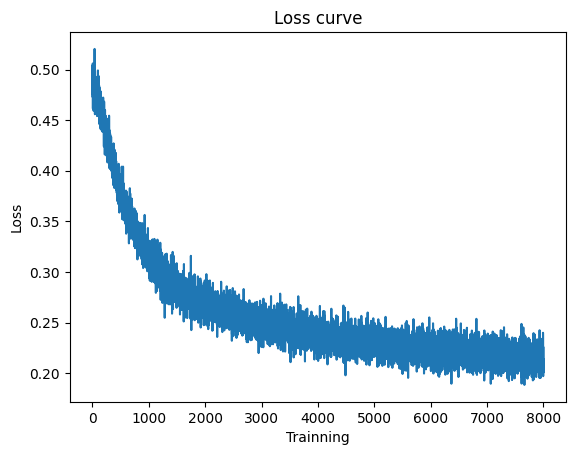

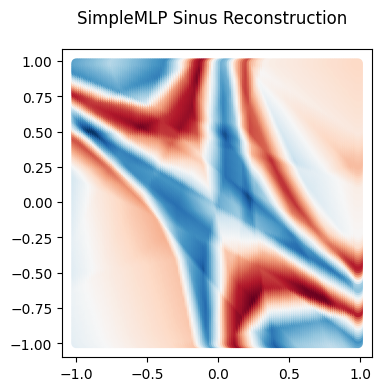

In [28]:
model = simple_mlp_Helmholtz()
train_model(model,create_dataset_hard(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=1,title="SimpleMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.509 
Epoch: 51, Loss_train: 0.047 
Epoch: 101, Loss_train: 0.038 
Epoch: 151, Loss_train: 0.044 
Epoch: 201, Loss_train: 0.043 
Epoch: 251, Loss_train: 0.039 
Epoch: 301, Loss_train: 0.041 
Epoch: 351, Loss_train: 0.036 
Epoch: 401, Loss_train: 0.038 
Epoch: 451, Loss_train: 0.037 
Finished with a loss for 100 last loss :  0.03858541
Finished with a loss for 50 last loss :  0.038633786
fourier_mlp_Helmholtz(
  (fourier_1): fourier_extract_full(in_features=2, out_features=81, bias=True)
  (fc_2): Linear(in_features=81, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=1, bias=True)
)


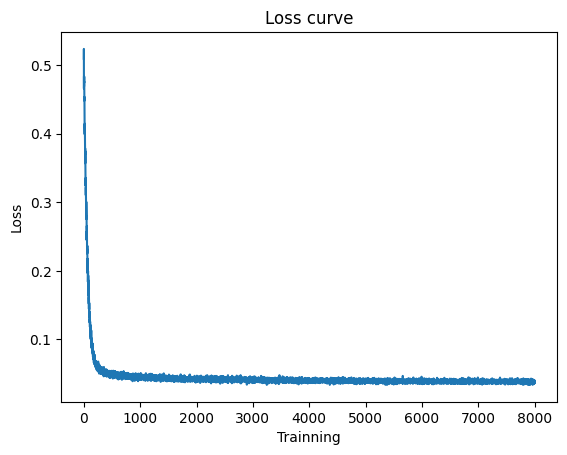

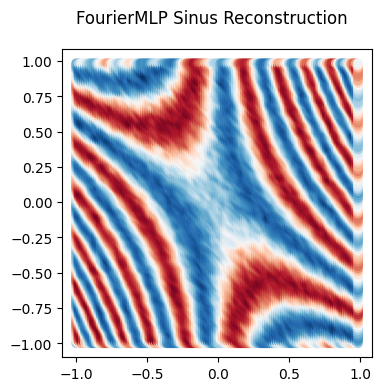

In [29]:
model = fourier_mlp_Helmholtz()
train_model(model,create_dataset_hard(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=2,title="FourierMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.990 
Epoch: 51, Loss_train: 0.045 
Epoch: 101, Loss_train: 0.044 
Epoch: 151, Loss_train: 0.047 
Epoch: 201, Loss_train: 0.049 
Epoch: 251, Loss_train: 0.043 
Epoch: 301, Loss_train: 0.045 
Epoch: 351, Loss_train: 0.044 
Epoch: 401, Loss_train: 0.043 
Epoch: 451, Loss_train: 0.045 
Finished with a loss for 100 last loss :  0.046302762
Finished with a loss for 50 last loss :  0.04631133
siren_mlp_Helmholtz(
  (siren): Siren(
    (net): Sequential(
      (0): SineLayer(
        (linear): Linear(in_features=2, out_features=32, bias=True)
      )
      (1): SineLayer(
        (linear): Linear(in_features=32, out_features=32, bias=True)
      )
      (2): SineLayer(
        (linear): Linear(in_features=32, out_features=1, bias=True)
      )
    )
  )
)


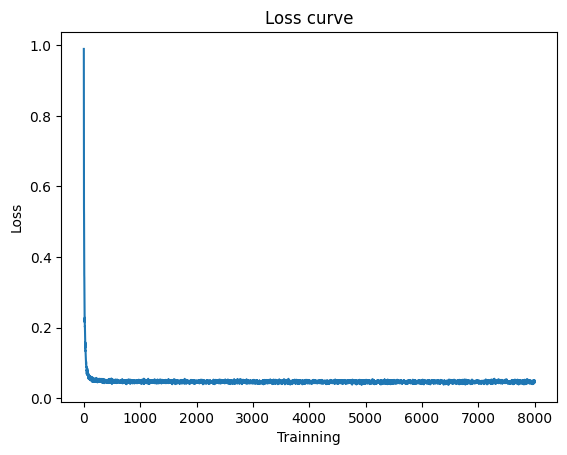

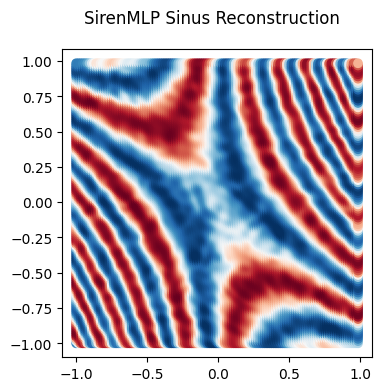

In [30]:
model = siren_mlp_Helmholtz()
train_model(model,create_dataset_hard(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=4,title="SirenMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.503 
Epoch: 51, Loss_train: 0.313 
Epoch: 101, Loss_train: 0.247 
Epoch: 151, Loss_train: 0.228 
Epoch: 201, Loss_train: 0.214 
Epoch: 251, Loss_train: 0.205 
Epoch: 301, Loss_train: 0.184 
Epoch: 351, Loss_train: 0.181 
Epoch: 401, Loss_train: 0.183 
Epoch: 451, Loss_train: 0.165 
Finished with a loss for 100 last loss :  0.16884948
Finished with a loss for 50 last loss :  0.16867138
triangular_mlp_Helmholtz(
  (input_decompo): triangular_features_extraction(in_features=2, out_features=16, bias=True)
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=1, bias=True)
)


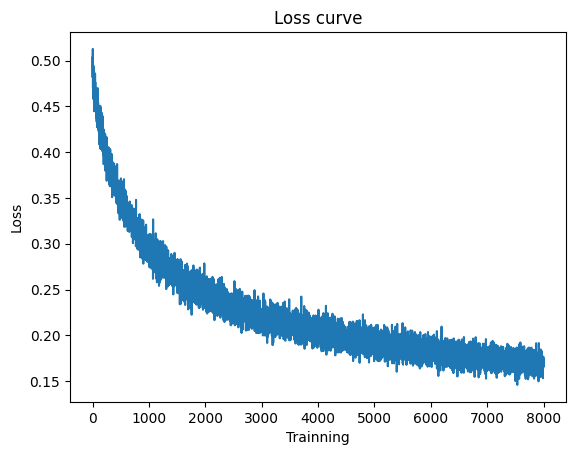

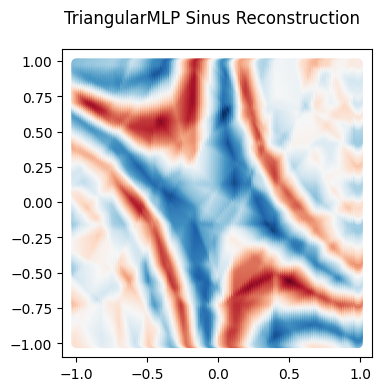

In [31]:
model = triangular_mlp_Helmholtz()
train_model(model,create_dataset_hard(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=5,title="TriangularMLP Sinus Reconstruction")
print(model)